# たくさんの指標を片っ端からdfに突っ込んで相関を見てみる

- 一つ一つの指標を作っては試し作っては試し、というやり方は非効率だからやめる。
- おそらく機械学習（あるいはその他の統計的な）手法で何らか意味のある特徴量を探索することになるが、その前に使えそうな指標をたくさん作って相関性を見てみる。
- 何か得られればさらに解析を進めるが、大きな収穫が無さそうならそこでやめておとなしく機械学習へ進む。

## やりたいこと
- 何らかの過去の指標（変数）と当日の値動き（終値 - 始値）との関係に相関性を見出す。

## 使う指標
※ 過去N日間のデータまで使う。
- 各日の値動き
    - 終値 - 始値
    - 高値 - 安値
    - 高値 - 終値
    - 始値 - 安値
- 2日間にわたる動き
    - ある日の終値 - 前日の終値
    - ある日の始値 - 前日の始値
    - ある日の安値 - 前日の安値
    - ある日の高値 - 前日の高値
    - ある日の出来高 - 前日の出来高
    - ある日の移動平均 - 前日の移動平均
- 過去N日間の最安値
- 過去N日間の最高値
- 各日の出来高

In [23]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import locale

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

In [24]:
df_raw = pd.read_csv('./data/N225minif_2020_exchange_daily.csv')
df_raw.info()
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3377 entries, 0 to 3376
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   日付      3377 non-null   object
 1   始値      3377 non-null   int64 
 2   高値      3377 non-null   int64 
 3   安値      3377 non-null   int64 
 4   終値      3377 non-null   int64 
 5   出来高     3377 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 158.4+ KB


,日付,始値,高値,安値,終値,出来高
0,2006/7/18,14680,14715,14400,14400,22345
1,2006/7/19,14500,14650,14465,14560,20646
2,2006/7/20,14860,14975,14780,14975,17398
3,2006/7/21,14840,14875,14790,14820,14689
4,2006/7/24,14685,14870,14560,14775,22641


# 分析するためのデータを作成
- 過去N日間の価格データを使えるようにする

In [25]:
# 過去N日間のデータを扱えるようにする
lastN = 5

# 元のデータを最も古い日（＝N日前）として扱う
df = df_raw.rename(
    columns={'日付': 'date', '始値': f'o{lastN}', '高値': f'h{lastN}', '安値': f'l{lastN}', '終値': f'c{lastN}', '出来高': f'v{lastN}'}
)

for i in reversed(range(lastN)):
    inc = lastN - i
    df[f'o{i}'] = df[f'o{lastN}'][inc:].append(pd.Series([np.nan]*inc)).reset_index(drop=True)
    df[f'h{i}'] = df[f'h{lastN}'][inc:].append(pd.Series([np.nan]*inc)).reset_index(drop=True)
    df[f'l{i}'] = df[f'l{lastN}'][inc:].append(pd.Series([np.nan]*inc)).reset_index(drop=True)
    df[f'c{i}'] = df[f'c{lastN}'][inc:].append(pd.Series([np.nan]*inc)).reset_index(drop=True)
    df[f'v{i}'] = df[f'v{lastN}'][inc:].append(pd.Series([np.nan]*inc)).reset_index(drop=True)

# 日付がN日分ずれているので補正
df['date'] = df['date'][lastN:].append(pd.Series(['-']*lastN)).reset_index(drop=True)

# 過去N日分のデータを使うため、最後のN日間のデータは欠損値が発生する
#（上記の処理でとりあえずnp.nanと'-'で埋めている）
# したがって最後のN日間のデータを削除
df = df[:-lastN]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3372 entries, 0 to 3371
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3372 non-null   object 
 1   o5      3372 non-null   int64  
 2   h5      3372 non-null   int64  
 3   l5      3372 non-null   int64  
 4   c5      3372 non-null   int64  
 5   v5      3372 non-null   int64  
 6   o4      3372 non-null   float64
 7   h4      3372 non-null   float64
 8   l4      3372 non-null   float64
 9   c4      3372 non-null   float64
 10  v4      3372 non-null   float64
 11  o3      3372 non-null   float64
 12  h3      3372 non-null   float64
 13  l3      3372 non-null   float64
 14  c3      3372 non-null   float64
 15  v3      3372 non-null   float64
 16  o2      3372 non-null   float64
 17  h2      3372 non-null   float64
 18  l2      3372 non-null   float64
 19  c2      3372 non-null   float64
 20  v2      3372 non-null   float64
 21  o1      3372 non-null   float64
 22  

# ターゲット指標は当日の値動き（終値 - 始値）とする

In [26]:
df['CODiff0'] = df['c0'] - df['o0']

# 指標の計算と追加

In [27]:
# 各日の値動き
for i in range(1, lastN+1):
    df[f'CODiff{i}'] = df[f'c{i}'] - df[f'o{i}'] # 終値 - 始値
    df[f'HLDiff{i}'] = df[f'h{i}'] - df[f'l{i}'] # 高値 - 安値
    df[f'HCDiff{i}'] = df[f'h{i}'] - df[f'c{i}'] # 高値 - 終値
    df[f'OLDiff{i}'] = df[f'o{i}'] - df[f'l{i}'] # 始値 - 安値

In [28]:
# N日移動平均
# とりあえず4日固定
# 例："C4Avg1" は、4日前～1日前までの4日移動平均値
nBars = 4
for i in range(1, (lastN+1) - (nBars-1)):
    df[f'C{nBars}Avg{i}'] = df[[f'c{j}' for j in range(i, i+nBars)]].mean(axis=1)

# ある日の移動平均 - 前日の移動平均
# 例："C4AvgSlope1" は、2日前の4日移動平均値から1日前の4日移動平均値への変化量
for i in range(1, (lastN+1) - (nBars-1) - 1):
    df[f'C{nBars}AvgSlope{i}'] = df[f'C{nBars}Avg{i}'] - df[f'C{nBars}Avg{i+1}']

In [29]:
# 2日間にわたる動き
for i in range(1, lastN):
    df[f'CSlope{i}'] = df[f'c{i}'] - df[f'c{i+1}'] # ある日の終値 - 前日の終値
    df[f'OSlope{i}'] = df[f'o{i}'] - df[f'o{i+1}'] # ある日の始値 - 前日の始値
    df[f'LSlope{i}'] = df[f'l{i}'] - df[f'l{i+1}'] # ある日の安値 - 前日の安値
    df[f'HSlope{i}'] = df[f'h{i}'] - df[f'h{i+1}'] # ある日の高値 - 前日の高値
    df[f'VSlope{i}'] = df[f'v{i}'] - df[f'v{i+1}'] # ある日の出来高 - 前日の出来高

In [30]:
# 過去N日間の最安値
df[f'L{lastN}min1'] = df[[f'l{n}' for n in range(1,lastN+1)]].min(axis=1)

# 過去N日間の最高値
df[f'H{lastN}max1'] = df[[f'h{n}' for n in range(1,lastN+1)]].max(axis=1)

In [31]:
# 指標として不要な列を削除
dfp = df.copy()
for i in range(lastN+1):
    dfp = dfp.drop([f'o{i}', f'c{i}', f'h{i}', f'l{i}', f'v{i}'], axis=1)

dfp = dfp.drop(['date'], axis=1)
dfp = dfp.drop([f'C{nBars}Avg{n}' for n in range(1, (lastN+1) - (nBars-1))], axis=1)

In [32]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3372 entries, 0 to 3371
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CODiff0      3372 non-null   float64
 1   CODiff1      3372 non-null   float64
 2   HLDiff1      3372 non-null   float64
 3   HCDiff1      3372 non-null   float64
 4   OLDiff1      3372 non-null   float64
 5   CODiff2      3372 non-null   float64
 6   HLDiff2      3372 non-null   float64
 7   HCDiff2      3372 non-null   float64
 8   OLDiff2      3372 non-null   float64
 9   CODiff3      3372 non-null   float64
 10  HLDiff3      3372 non-null   float64
 11  HCDiff3      3372 non-null   float64
 12  OLDiff3      3372 non-null   float64
 13  CODiff4      3372 non-null   float64
 14  HLDiff4      3372 non-null   float64
 15  HCDiff4      3372 non-null   float64
 16  OLDiff4      3372 non-null   float64
 17  CODiff5      3372 non-null   int64  
 18  HLDiff5      3372 non-null   int64  
 19  HCDiff

/home/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures crea

/home/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures crea

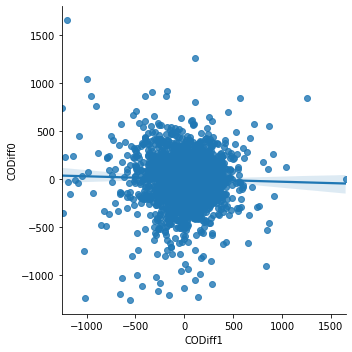

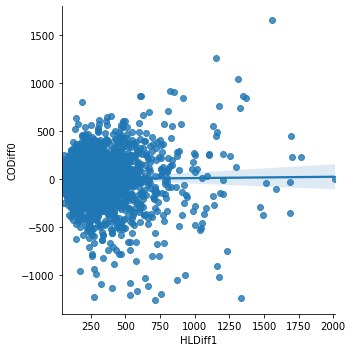

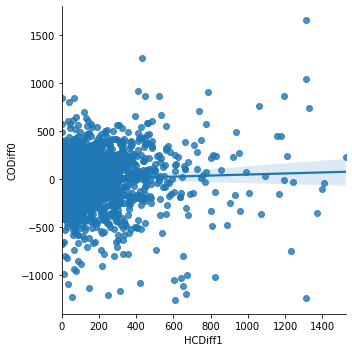

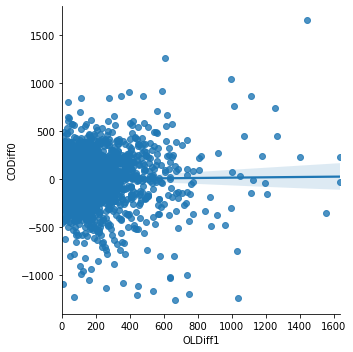

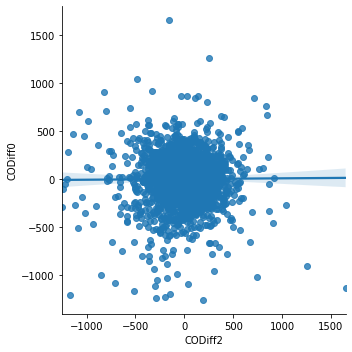

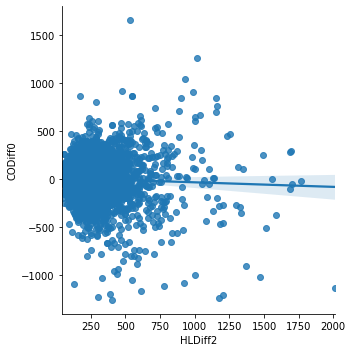

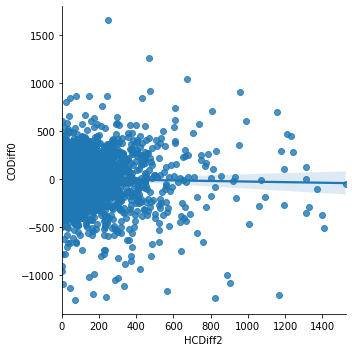

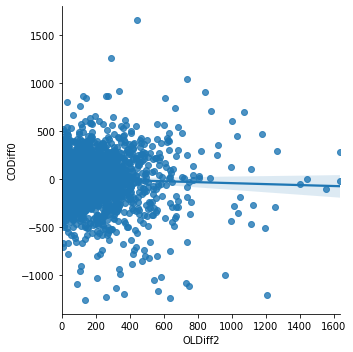

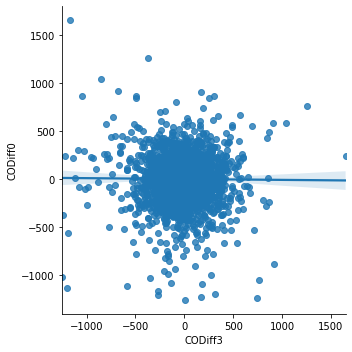

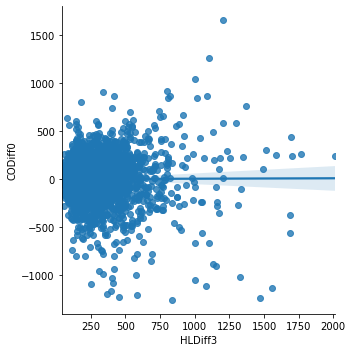

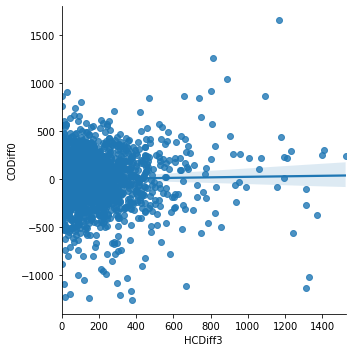

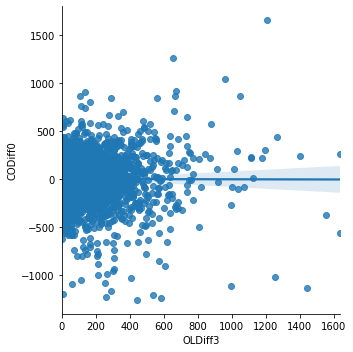

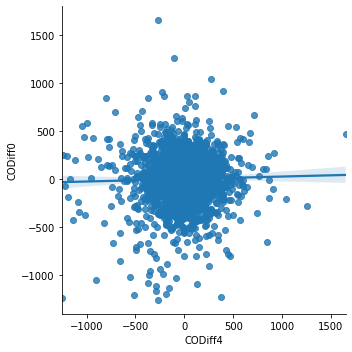

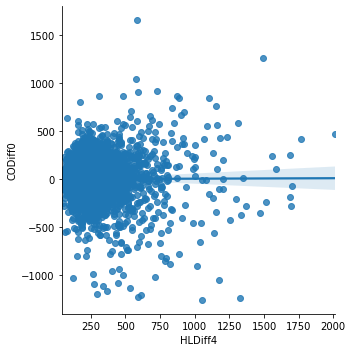

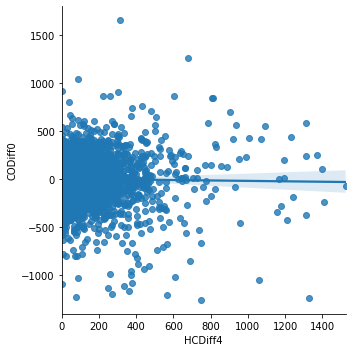

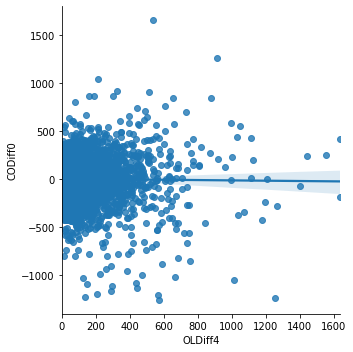

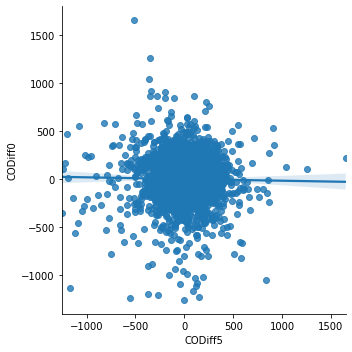

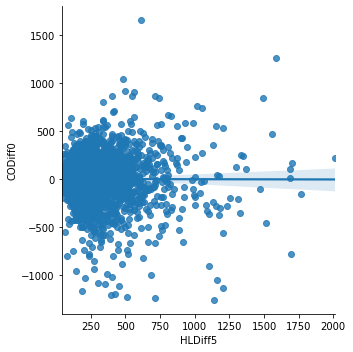

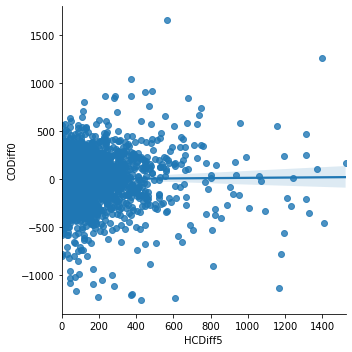

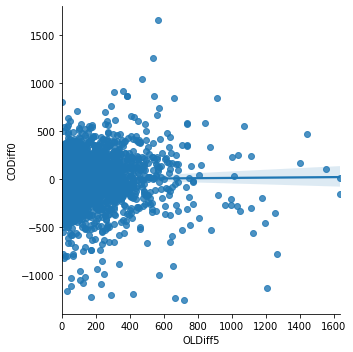

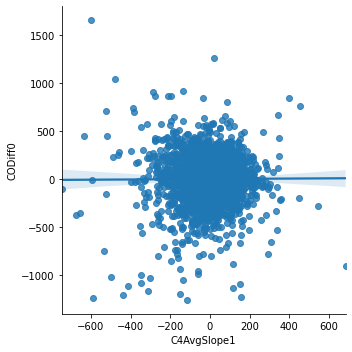

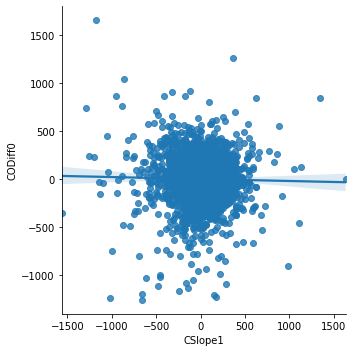

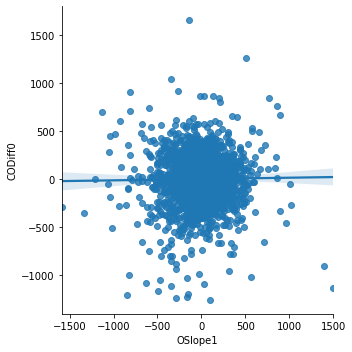

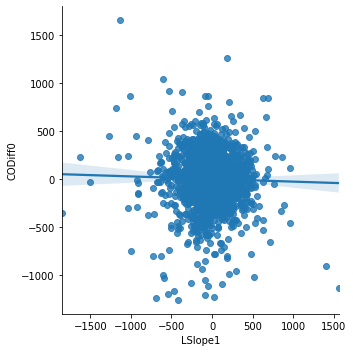

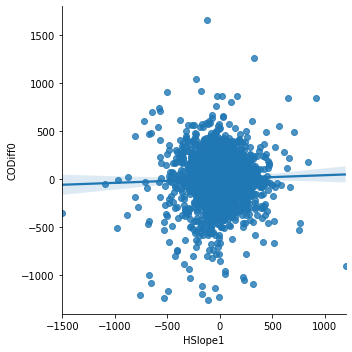

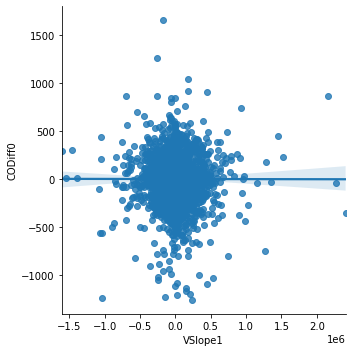

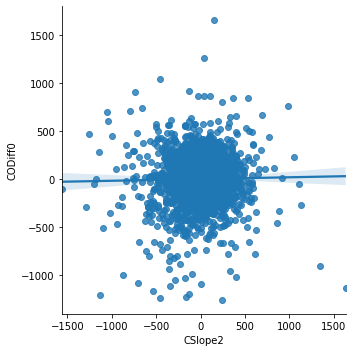

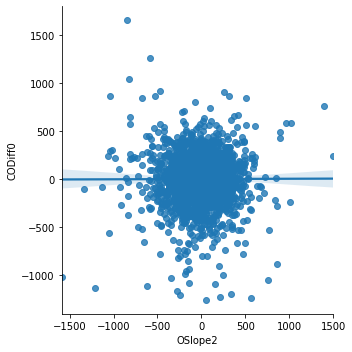

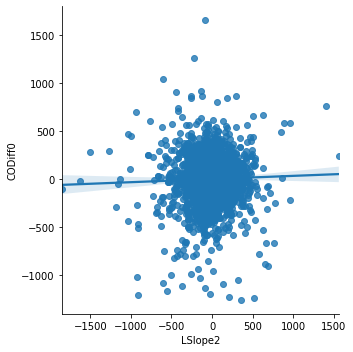

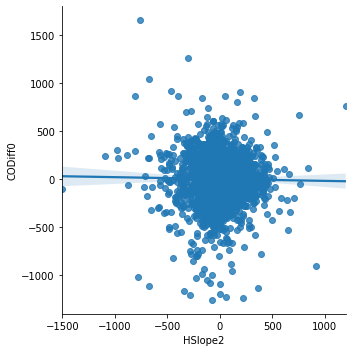

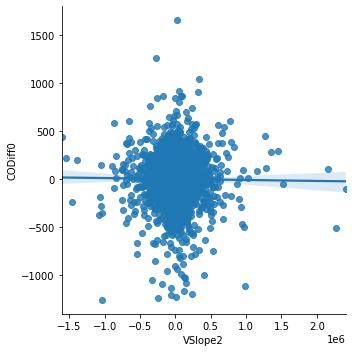

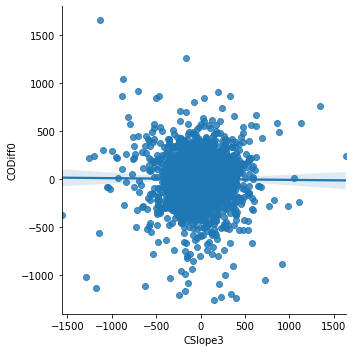

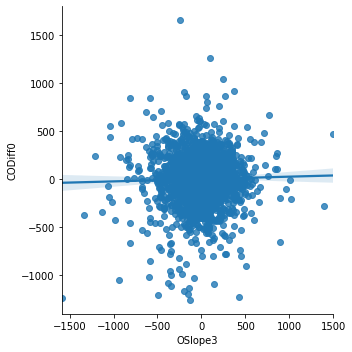

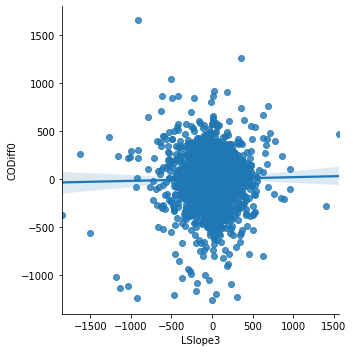

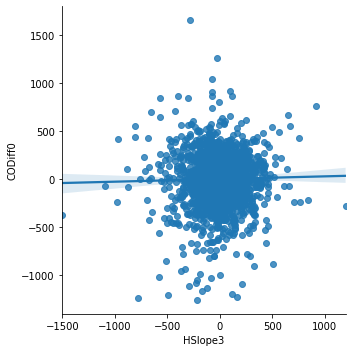

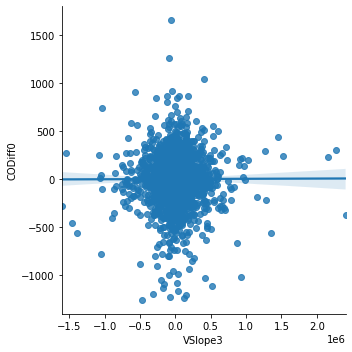

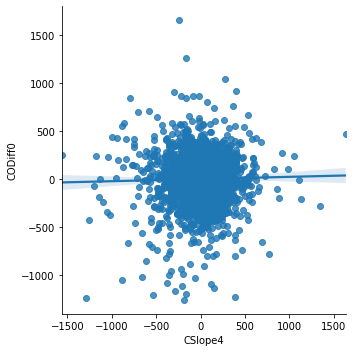

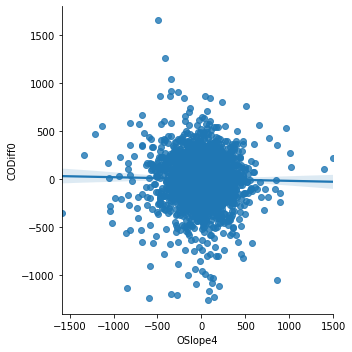

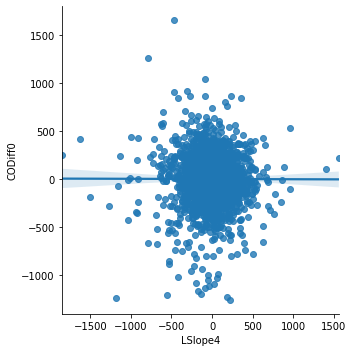

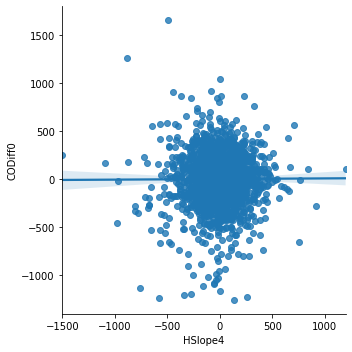

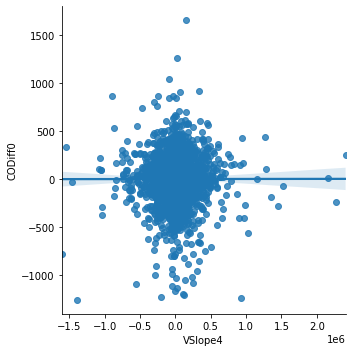

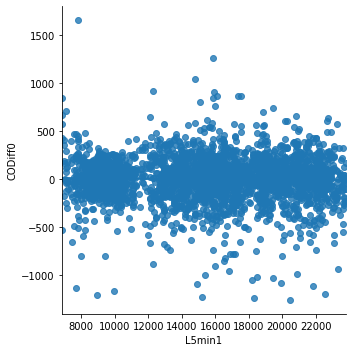

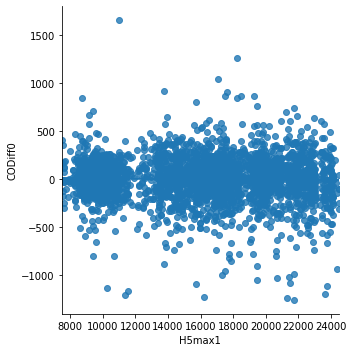

In [40]:
# 'CODiff0'と他の指標との関係を回帰プロットする
SAVE_DIR = 'plots/NIKKEI225mini-EDA-05'
def plot_save(x_label, data):
    target = 'CODiff0'
    plot = sns.lmplot(x_label, target, data=dfp)
    plot.savefig(f'{SAVE_DIR}/lmplot_{x_label}_{target}.png')

for x_label in dfp.columns:
    if x_label == 'CODiff0':
        continue

    plot_save(x_label, dfp)